In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imagesize=256
batchsize=32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(imagesize,imagesize),
    batch_size=batchsize
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


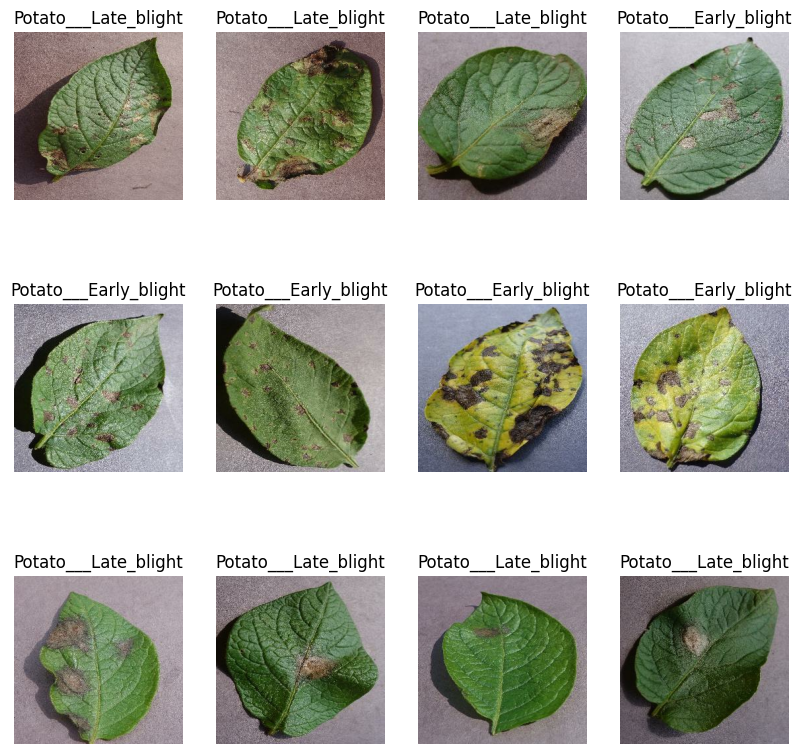

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [ ]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1,test_ratio = 0.1, shuffle=True, shuffle_size=10000):
    assert (train_ratio + test_ratio + val_ratio) == 1

    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)


    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 54, Validation size: 6, Test size: 8


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(imagesize, imagesize),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
channels = 3
input_shape = (imagesize, imagesize, channels)
n_classes = 3

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = "resnet_model.keras"

resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in resnet50_base.layers:
    layer.trainable = False


resnet_model = models.Sequential([
    resize_and_rescale,
    resnet50_base,  # Use resnet50_base here
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])
resnet_model.build(input_shape=(None, imagesize, imagesize, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#callbacks1 = [
    #ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    #EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#]

In [ ]:
history = resnet_model.fit(
    train_ds,
    batch_size=batchsize,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    #callbacks=callbacks1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 278s 802ms/step - accuracy: 0.4443 - loss: 1.2833 - val_accuracy: 0.4792 - val_loss: 0.8506
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 770ms/step - accuracy: 0.5701 - loss: 0.8516 - val_accuracy: 0.4792 - val_loss: 0.8633
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 594ms/step - accuracy: 0.6389 - loss: 0.8110 - val_accuracy: 0.7083 - val_loss: 0.7539
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 627ms/step - accuracy: 0.6235 - loss: 0.8327 - val_accuracy: 0.7344 - val_loss: 0.7376
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.6966 - loss: 0.7579 - val_accuracy: 0.7344 - val_loss: 0.7001
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 618ms/step - accuracy: 0.7108 - loss: 0.7099 - val_accuracy: 0.7552 - val_loss: 0.6983
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 592ms/step - accuracy: 0.7336 - loss: 0.6975 - val_accuracy: 0.7552 - val_loss: 0.6995
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - accuracy: 0.7301 - loss: 0.6925 - val_acc

In [ ]:
scores = resnet_model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7945 - loss: 0.5136


In [ ]:
def plot_training_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Train Acc')
    plt.plot(epochs, val_acc, 'b', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_training_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Train Acc')
    plt.plot(epochs, val_acc, 'b', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
def plot_confusion_matrix(model, dataset, class_names):
    y_true, y_pred = [], []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

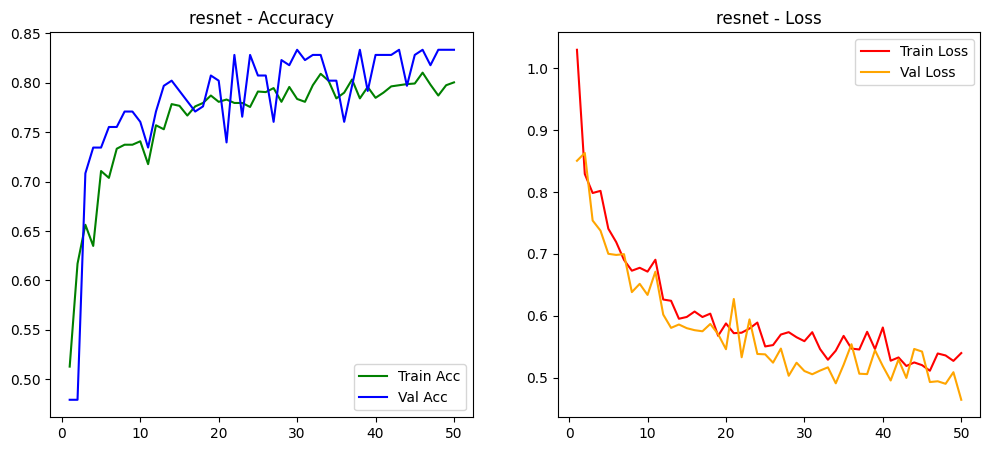

In [ ]:
class_names = ["Early Blight", "Late Blight", "Healthy"]
plot_training_history(history, title="resnet")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


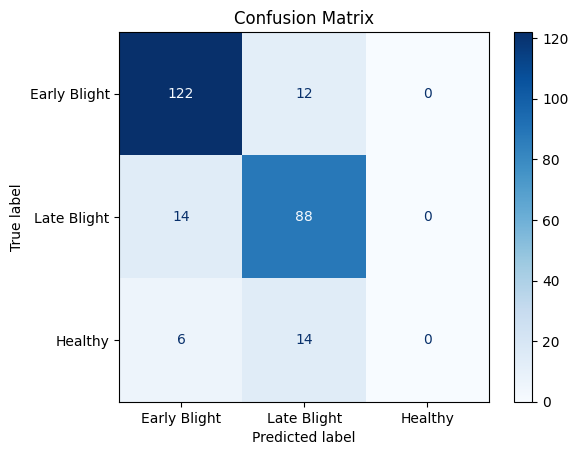


 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.86      0.91      0.88       134
 Late Blight       0.77      0.86      0.81       102
     Healthy       0.00      0.00      0.00        20

    accuracy                           0.82       256
   macro avg       0.54      0.59      0.57       256
weighted avg       0.76      0.82      0.79       256

Accuracy:  0.8203
Precision: 0.7573
Recall:    0.8203
F1 Score:  0.7874


In [ ]:
plot_confusion_matrix(resnet_model, test_ds, class_names)

first image to predict
actual label: Late Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
predicted label: Late Blight


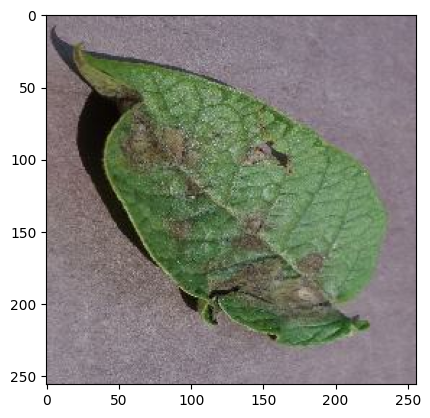

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = resnet_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


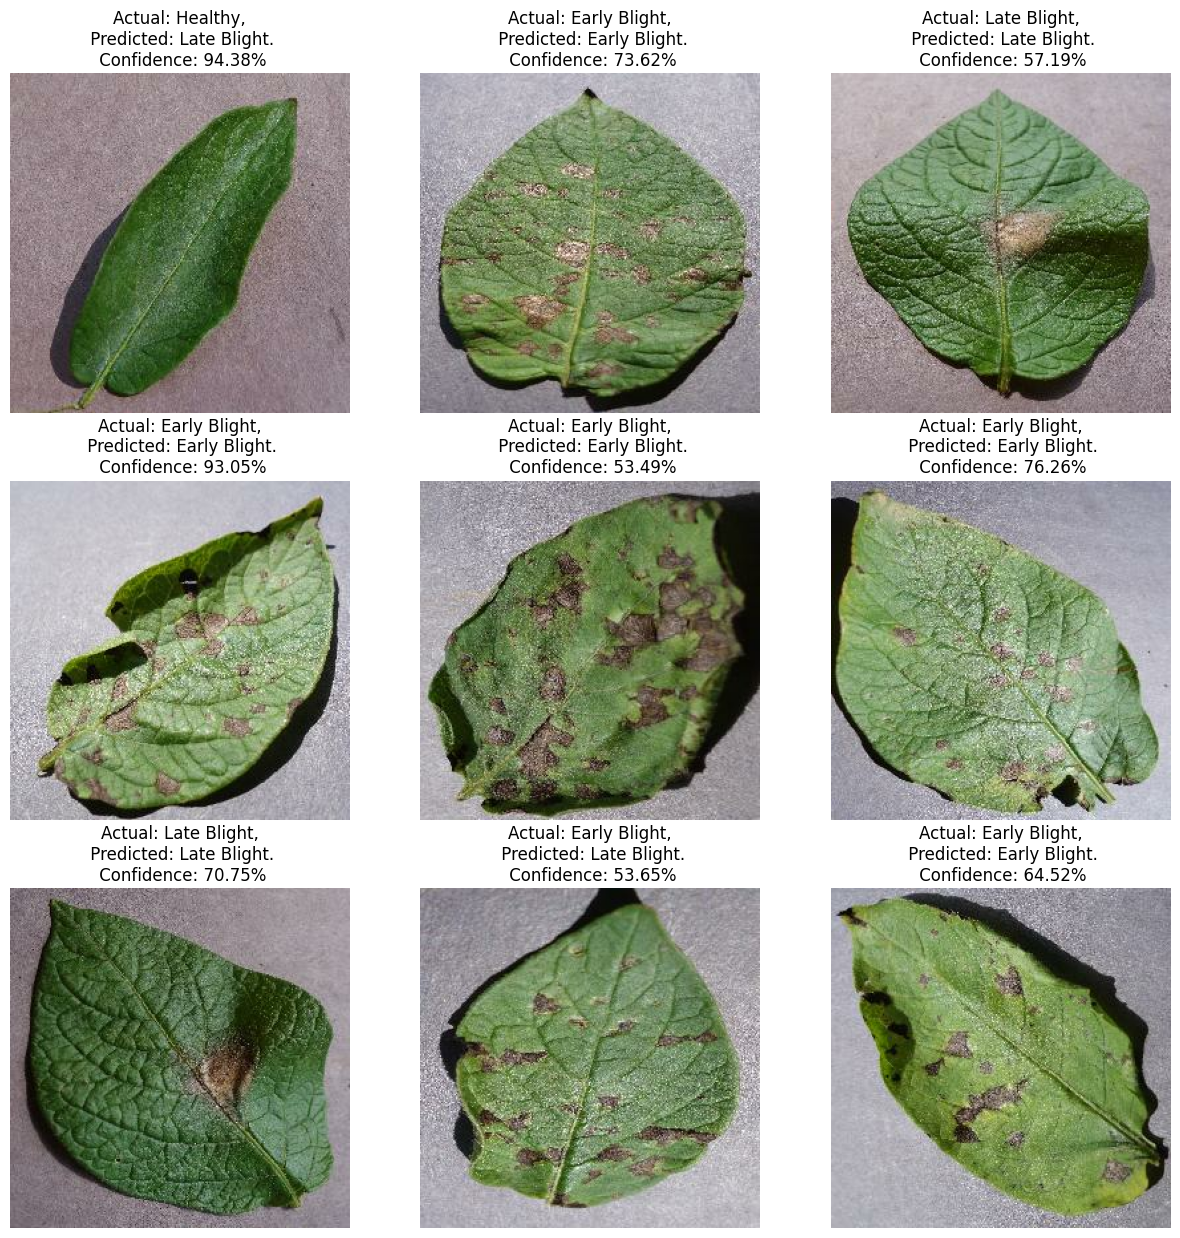

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(resnet_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
resnet_model.save("resnet.h5")

In [ ]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


model = load_model("resnet.h5",compile=False)


class_names = ["Early Blight", "Late Blight", "Healthy"]

def load_and_preprocess_image(path, target_size=(256, 256)):
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)
    img_array = np.array(image)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


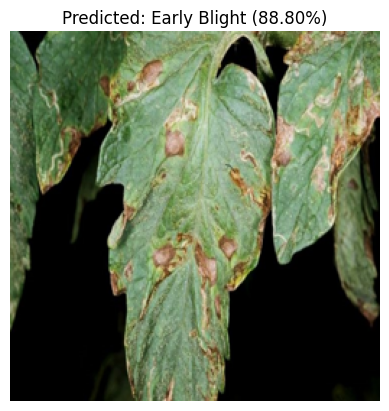

In [ ]:
image_path ="/content/a_solani.jpg"
img_array, original_image = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

plt.imshow(original_image)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
plt.show()